# Self-learning Project - Stock Prediction

Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation using the past 60 days stock price.

In [1]:
# Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#Get stock quote
company = 'AAPL'
start_date = '2015-01-01'
end_date = '2021-12-31'
df = web.DataReader(company, data_source='yahoo', start=start_date, end=end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,28.282499,27.552500,28.205000,27.594999,165613600.0,24.951864
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.714506
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.018263
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.020523
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.357342


In [3]:
#Check for number of entries
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1764 entries, 2014-12-31 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1764 non-null   float64
 1   Low        1764 non-null   float64
 2   Open       1764 non-null   float64
 3   Close      1764 non-null   float64
 4   Volume     1764 non-null   float64
 5   Adj Close  1764 non-null   float64
dtypes: float64(6)
memory usage: 96.5 KB


In [4]:
#Summary of data
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1764.000000,1764.000000,1764.000000,1764.000000,1.764000e+03,1764.000000
mean,61.984515,60.701275,61.329983,61.373359,1.380318e+08,59.828320
std,40.791953,39.828676,40.301245,40.337350,6.976581e+07,40.870568
min,22.917500,22.367500,22.500000,22.584999,4.100000e+07,21.009529
25%,31.731250,31.235625,31.504375,31.473125,9.039990e+07,28.654940
50%,44.332500,43.627501,43.865000,43.966251,1.189708e+08,42.348808
75%,78.218752,76.302502,77.147501,77.390627,1.654590e+08,76.220520
max,182.130005,178.529999,181.119995,180.330002,6.488252e+08,180.100540


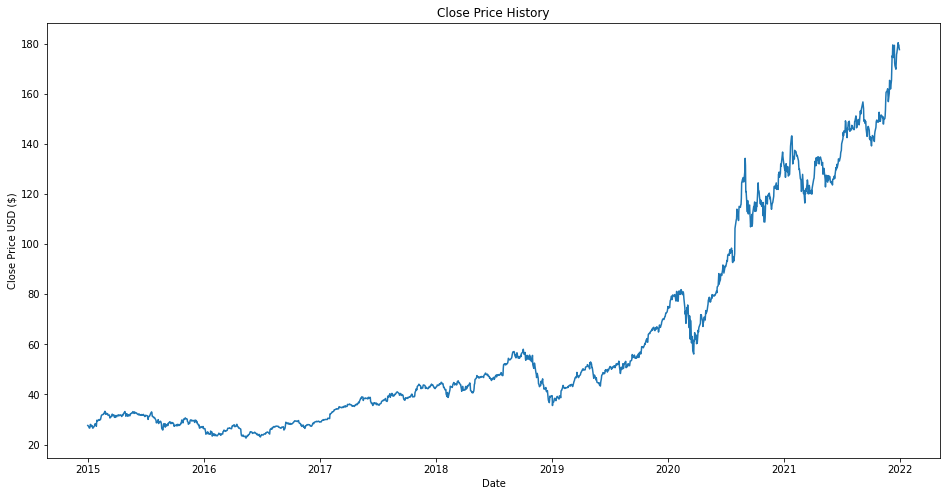

In [5]:
#Plot line graph
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

Scaler.fit_transform() should be executed on the training data instead of the entire dataset. If executed on the entire dataset, then the mean and variance are calculated on the entire dataset (with test data included). This will bias the model with information from the test data. The correct step should be execute scaler.fit_transform() on the training data at first, and then execute scaler.transform() on the test data.

This is also known as data leakage

In [20]:
#Create new dataframe with Close column only
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get training data length (0.8)
training_data_len = math.ceil(len(dataset) * 0.8)
train_data = dataset[:training_data_len]
train_data

array([[ 27.59499931],
       [ 27.33250046],
       [ 26.5625    ],
       ...,
       [113.90249634],
       [111.11250305],
       [112.72750092]])

In [7]:
#Scale training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.03176012],
       [0.03009605],
       [0.02521475],
       ...,
       [0.99397764],
       [0.98649716],
       [0.98250344]])

In [8]:
#Create the training dataset
prediction_days = 60
x_train = []
y_train = []

#Append 60 days of closing price to x_train and the result (61 day) to y_train
for i in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append([scaled_data[i,0]])
    
# Prepare training dataset to numpy array for the model training later
x_train , y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [9]:
#Build the LSTM model
model = Sequential()
#50 neurons, return_sequences=True because we going to use another LSTM layer, 
#since this LSTM is the first layer, we will add the input_shape
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
#50 neurons, return_sequences=False because there is no more LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
#Compile the model
#Optimizer is used to improve upon the loss function and the loss function is used how the model did in training
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
#Train the model
#epochs = Number of interations on a dataset
model.fit(x_train, y_train, batch_size=1, epochs=1)

1704/1704 [==============================] - 40s 22ms/step - loss: 0.0017


In [12]:
#Create the testing dataset
#Create a new array containing scaled values from index of training_data_len to last item
test_data = dataset[training_data_len-prediction_days:, :]
actual_prices = dataset[training_data_len:, :]
#Scale the test_data
test_data = scaler.transform(test_data)

In [13]:
#Create the dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [14]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [15]:
#Reshape and scale the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

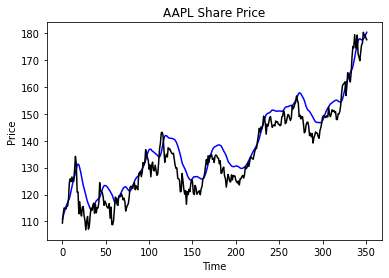

In [16]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
plt.plot(predictions, color="blue", label="Predicted Prices")
plt.plot(actual_prices, color="black", label="Actual Prices")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [17]:
#evaluate the model performance
mse = mean_squared_error(y_test, predictions)
rmse = (np.sqrt(mean_squared_error(y_test, predictions)))
rmse

5.452193820230863

In [18]:
r2 = r2_score(y_test, predictions)
r2

0.8870741586129819

In [25]:
final_test = dataset[len(dataset) - prediction_days:len(dataset)+1]
final_test = scaler.transform(final_test)
final_test = np.array([final_test])
final_test = np.reshape(final_test, (final_test.shape[0], final_test.shape[1],1))

In [26]:
final_prediction = model.predict(final_test)
final_prediction = scaler.inverse_transform(final_prediction)
print(final_prediction[0][0])

[[1.0027059]]
180.75684
